# 1. Загрузка библиотек и базовые настройки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve

from IPython.display import display, Markdown
from imblearn.over_sampling import RandomOverSampler

# 2. Задаем функцию для рассчета целевых метрик

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

# 3. Загрузка датасетов

In [3]:
train_df = pd.read_csv('course_project_train.csv')
test_df = pd.read_csv('course_project_test.csv')

In [4]:
train_df.loc[train_df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

# 4. Создание класса для обработки данных

In [5]:
class Data:
    
    def __init__(self):
        
        self.medians = None
        self.Years_in_current_job = None
        self.Months_since_last_delinquent = None
        
        
    # уменьшение занимаемой памяти
    def reduce_mem_usage(self, df):
    
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        
        return df

    
    # Расчет медиан и мод на тренировочном датасете
    def fit(self, df):
        
        self.medians = df.median()
        self.Years_in_current_job = df['Years in current job'].mode()[0]
        self.Months_since_last_delinquent = df['Months since last delinquent'].mode()[0]
        self.Bankruptcies = df['Bankruptcies'].mode()[0]
        return df
              
        
    # Работа с признаками
    def transform(self, df):
            
        df.loc[df['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']   
        df.loc[df['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']   
        
        df.loc[df['Years in current job'].isna(), 'Years in current job'] = self.Years_in_current_job
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = self.Months_since_last_delinquent
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = self.Bankruptcies

        
        df['Home Ownership'] = df['Home Ownership'].map({'Own Home':'0', 'Rent':'1', 'Home Mortgage':'2',
                                                         'Have Mortgage':'2'}).astype(int)

        df['Years in current job'] = df['Years in current job'].map({'< 1 year':'0', '1 year':'1', '2 years':'2',
                                                                     '3 years':'3', '4 years':'4', '5 years':'5',
                                                                     '6 years':'6', '7 years':'7', '8 years':'8',
                                                                     '9 years':'9', '10+ years':'10',}).astype(int)

        df['Term'] = df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
        
        df.loc[df['Tax Liens'] != 0, 'Tax Liens'] = 1
    
        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
        df.drop(['Purpose'], inplace=True, axis=1)
        
        return df
    
    def robust(self, df):

        df.loc[:, train_df.drop('Credit Default', axis=1).columns.to_list()] = robust_scaler.transform(df.loc[:, train_df.drop('Credit Default', axis=1).columns.to_list()])
        return df

In [6]:
preprocessor = Data()

# 5. Уменьшение занимаемой памяти

_Привожу датасеты к формату, который мне нравится - чтобы использовался действительно максимальный необходимый формат для передачи значений признака._

In [7]:
train_df = preprocessor.reduce_mem_usage(train_df)
test_df = preprocessor.reduce_mem_usage(test_df)

# 6. EDA тренировочного датасета

## а. Общий вид

_Выводим информацию о том, сколько строк и столбцов в тренировочном  и тестовом датасетах._

In [8]:
train_df.shape

(7500, 17)

In [9]:
test_df.shape

(2500, 16)

_Выводим общую информацию о признаках в тренировочном датасете._

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

## b. Анализ количественных переменных

_Выводим статистики количественных переменных. Анализируем их._

In [11]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


_Далее анализируем распределение значений признаков._

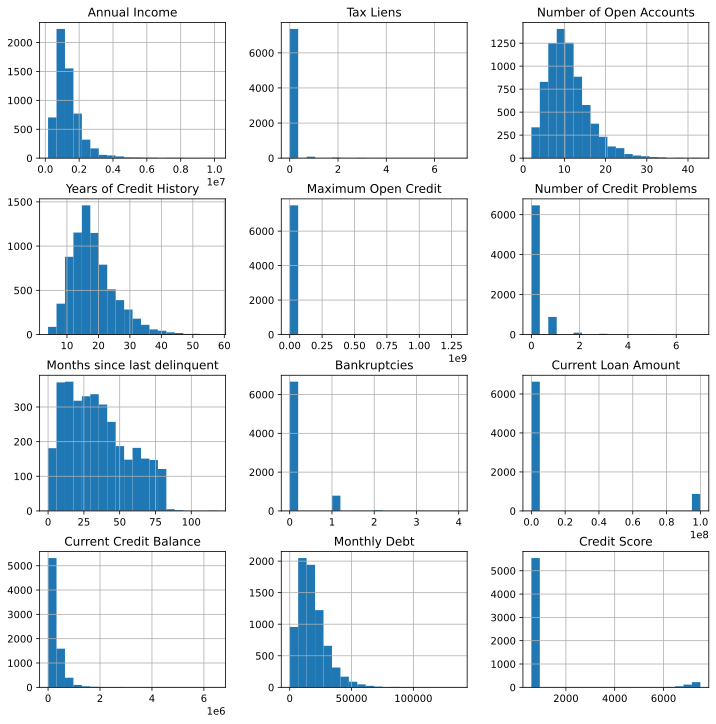

In [12]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
train_df_num_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

## с. Анализ номинальных переменных

_Также анализируем распределение номинальных признаков._

In [13]:
train_df_cat_features = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'category'])
for col in train_df_cat_features:
        un_n = train_df[col].nunique()
        uniqset = np.array(train_df[col].unique())
        print(f'no of unique {col}: {un_n}')
        print(f'{uniqset} \n')

no of unique Home Ownership: 4
['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage'] 

no of unique Years in current job: 11
[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years'] 

no of unique Purpose: 14
['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation'] 

no of unique Term: 2
['Short Term' 'Long Term'] 

no of unique Credit Default: 2
[0 1] 



## d. Поиск аномалий

_Анализ выбросов проводился по boxplot._

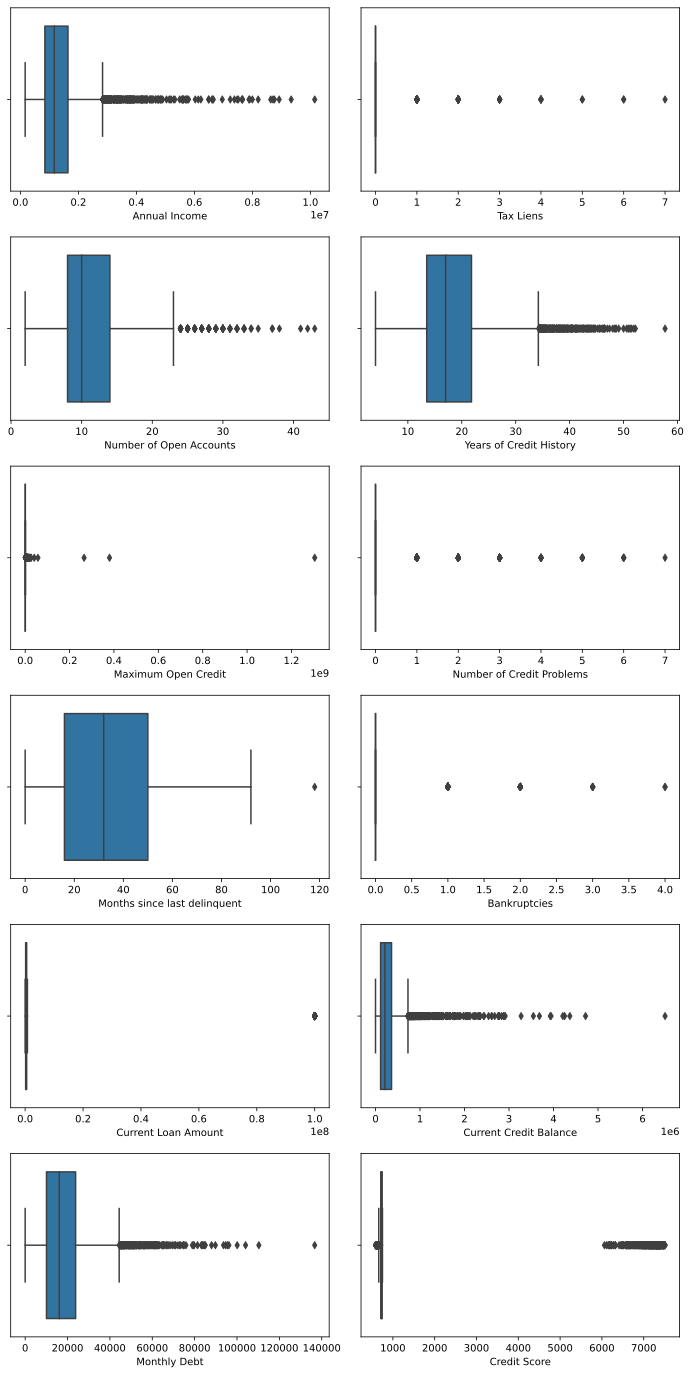

In [14]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, 
                         sharey = True,
                         figsize=(12, 24)
                        )

feature_names = train_df_num_features

for feature, ax in zip(feature_names, axes.flatten()):
    ax.plot(ax=axes, label=feature)
    sns.boxplot(x=feature, data=train_df, ax=ax)

fig.subplots_adjust(hspace=0.25, wspace=0.1)

# 7. Обработка пропусков и выбросов, генерация дамми-переменных

In [15]:
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [16]:
robust_scaler = preprocessing.RobustScaler().fit(train_df[train_df.drop('Credit Default', axis=1).columns.to_list()])

train_df = preprocessor.robust(train_df)
test_df = preprocessor.robust(test_df)

_Определение мод и медиан делается именно на тренировочном сете, потом эти значения используются как в тренировочном, так и в тестовом наборах данных._

# Промежуточные выводы №1

###### Обработаны пропуски .
###### Подготовлены признаки для обучения модели.

# 8. Разделение тренировочного датасета на собственно тренировочный и валидационный

In [17]:
def with_over_sample(df):
    X_train = df.drop(columns = 'Credit Default')
    y_train = df['Credit Default']
    ros = RandomOverSampler(sampling_strategy=0.6)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train

In [18]:
X, y = with_over_sample(train_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=100)

# 9. Тренировка финальной модели

_Среди всех использованных моделей лучшую метрику показала логистическая регрессия, поэтому использовалась именно она с гиперпараметрами, определенными с помощью GridSearch_

In [19]:
final_model = LogisticRegression(C=2.833, max_iter=1000)

final_model.fit(X_train, y_train)

LogisticRegression(C=2.833, max_iter=1000)

# 10. Валидация

_Задаем функцию для рассчета порога классификации на основании определения максимальной F1_

In [20]:
def find_threshold(model, x_test, y_test):
    probs = model.predict_proba(x_test)
    probs = probs[:, 1]
    precision, recall, trashhold = precision_recall_curve(y_test, probs)
    maximing_score = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(maximing_score)
    threshold = trashhold[ix]
    return threshold

In [21]:
threshold = find_threshold(final_model, X_train, y_train)

y_train_scores = final_model.predict_proba(X_train)[:, 1]
y_test_scores = final_model.predict_proba(X_test)[:, 1]

y_train_preds = (y_train_scores >= threshold).astype(int)
y_test_preds = (y_test_scores >= threshold).astype(int)

get_classification_report(y_train, y_train_preds, y_test, y_test_preds)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.44      0.58      4301
           1       0.49      0.89      0.63      2594

    accuracy                           0.61      6895
   macro avg       0.68      0.67      0.61      6895
weighted avg       0.73      0.61      0.60      6895

TEST

              precision    recall  f1-score   support

           0       0.86      0.43      0.57      1086
           1       0.48      0.88      0.62       638

    accuracy                           0.60      1724
   macro avg       0.67      0.66      0.60      1724
weighted avg       0.72      0.60      0.59      1724

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               469  617
1                77  561


# Промежуточные выводы №2

###### Обучены несколько моделей, выбрана показавшая лучшую метрику -  Логистическая регрессия.
###### Проанализировано качество работы модели на трейне и валидационном датасете.

# 11. Собственно предсказание

In [22]:
y_valid = final_model.predict_proba(test_df)[:, 1]
predictions = (y_valid >= threshold).astype(int)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])

predictions_df.to_csv('AErmak_predictions.csv', index = False)
predictions_df.sample(5)

,predictions
1359,0
546,1
1792,0
1263,0
1810,0
